Epoch 2: Loss = 0.24215678984328406
Epoch 3: Loss = 0.117351089861059
Epoch 4: Loss = 0.04572538830811936
Epoch 5: Loss = 0.017932543575884665
Epoch 6: Loss = 0.008112147327942978
Epoch 7: Loss = 0.004541665631508351
Epoch 8: Loss = 0.0031170457294510357
Epoch 9: Loss = 0.0024352149027109605
Epoch 10: Loss = 0.00204598748387145
Epoch 12: Loss = 0.0016514049348295501
Epoch 13: Loss = 0.001539427637143298
Epoch 14: Loss = 0.0014456251077982075
Epoch 15: Loss = 0.0013693120056814223
Epoch 16: Loss = 0.001308069380108856
Epoch 17: Loss = 0.0012500048135404996
Epoch 18: Loss = 0.0011938994606706288
Epoch 19: Loss = 0.001146375605911203
Epoch 20: Loss = 0.0011016171282447118
Epoch 22: Loss = 0.0010147051446904242
Epoch 23: Loss = 0.0009775010554778875
Epoch 24: Loss = 0.0009418769174345698
Epoch 25: Loss = 0.0009050952865490913
Epoch 26: Loss = 0.0008751237483465956
Epoch 27: Loss = 0.0008448910691237189
Epoch 28: Loss = 0.0008153314860783211
Epoch 29: Loss = 0.0007873936344151389
Epoch 30: 

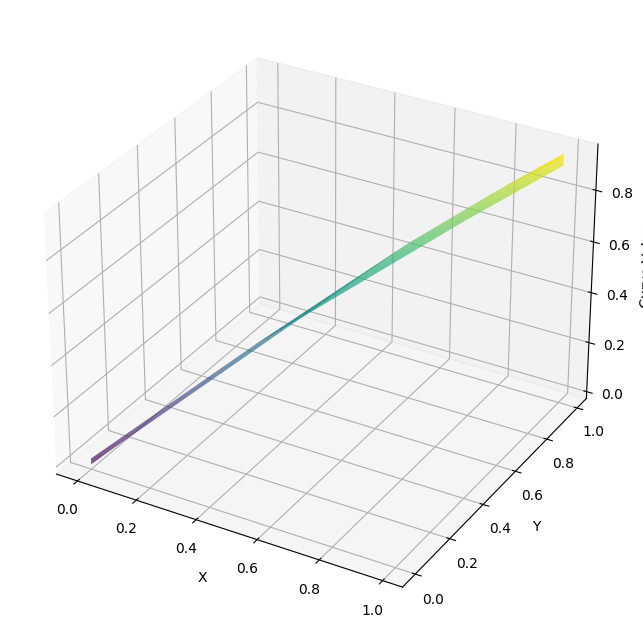

In [17]:
import numpy as np
import torch
import torch.nn as nn

# Step 1: Generate Data
x = np.arange(0, 1, 0.01)
y = np.sin(2 * np.pi * x) + 0.001 * np.random.randn(len(x))

# Step 2: Define your model
class CurveFitter(nn.Module):
    def __init__(self):
        super(CurveFitter, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 3: Define your loss function and optimizer
model = CurveFitter()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Step 4: Train your model
for epoch in range(100):
    running_loss = 0.0
    for i in range(len(x)):
        inputs = torch.tensor([x[i], y[i]], dtype=torch.float32)
        labels = torch.tensor([np.sin(2 * np.pi * x[i])], dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if epoch%10: print(f"Epoch {epoch+1}: Loss = {running_loss/len(x)}")

# Step 5: Use your model to predict the curve values
x_test = np.arange(0, 1, 0.01)
y_test = np.arange(0, 1, 0.01)
curve_predictions = []

for i in range(len(x_test)):
    for j in range(len(y_test)):
        inputs = torch.tensor([x_test[i], y_test[j]], dtype=torch.float32)
        prediction = model(inputs).item()
        curve_predictions.append(prediction)

curve_predictions = np.array(curve_predictions).reshape(len(x_test), len(y_test))

# Plot the results
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_test, y_test, curve_predictions, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Curve Value')
plt.show()


IndexError: index 49 is out of bounds for axis 1 with size 1

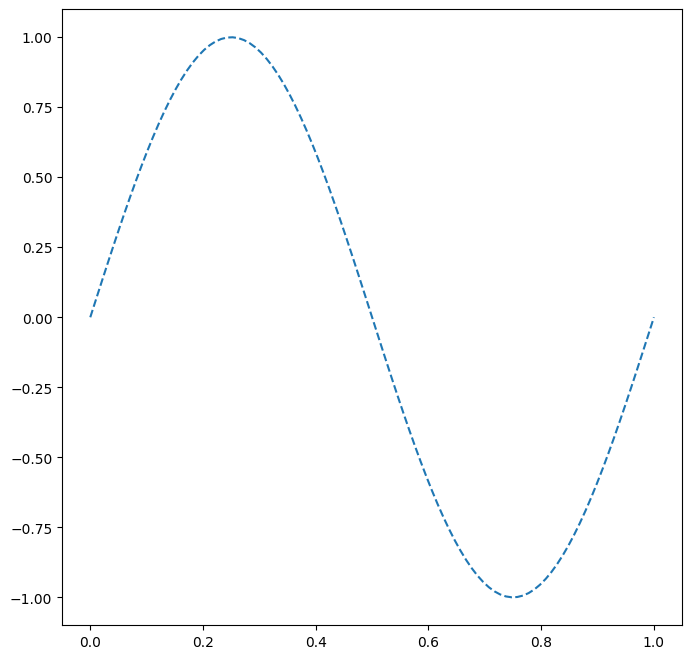

In [16]:
import matplotlib.pyplot as plt

# Generate test input values
x_test = torch.linspace(0, 1, 100)
y_test = torch.linspace(-1, 1, 100)

# Compute curve predictions for test input values
curve_predictions = model(torch.stack([x_test, y_test], axis=1)).detach().numpy()

# Plot the curve in the xy-plane
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(x_test, np.sin(2*np.pi*x_test), label='True Curve', linestyle='--')
ax.plot(x_test, curve_predictions[:, 49], label='Predicted Curve')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()
